# Analizar geometría sísmica y generar geometrías de sub-muestreo

### Cargar librerías requeridas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
from fiona.crs import from_epsg
import seaborn as sns
import contextily as cx


In [2]:
!pip3 install contextily

In [3]:
#reference system for Magna Sirgas Bogota zone
epsg = 3116

## 1. Analizar geometría

### 1.1. Cargar los datos de la geometría a analizar

In [4]:
receiver_survey = gpd.GeoDataFrame.from_file('../data_geometry/receiver_POSTPLOT_shapefile/receiver_shapes_tenerife.shp')
source_survey = gpd.GeoDataFrame.from_file('../data_geometry/source_POSTPLOT_shapefile/source_shapes_tenerife.shp')

In [5]:
receiver_survey

,RECEIVERSE,UNKNOWN2,ESTE,NORTE,ELEVACION,UNKNOWN2_1,TYPE,geometry
0,R3000,10371G1,1025139.0,1252080.9,92.0333,134217,receiver,POINT (1025139.000 1252080.900)
1,R3000,10381G1,1025158.3,1252077.6,91.5333,134217,receiver,POINT (1025158.300 1252077.600)
2,R3000,10391G1,1025178.6,1252074.0,94.7333,134217,receiver,POINT (1025178.600 1252074.000)
3,R3000,10401G1,1025198.0,1252070.6,97.1333,134217,receiver,POINT (1025198.000 1252070.600)
4,R3000,10411G1,1025217.6,1252067.3,100.0333,134217,receiver,POINT (1025217.600 1252067.300)
...,...,...,...,...,...,...,...,...
4327,R3252,11781G1,1028791.4,1256555.0,137.2344,90614,receiver,POINT (1028791.400 1256555.000)
4328,R3252,11791G1,1028811.2,1256551.5,135.7344,90614,receiver,POINT (1028811.200 1256551.500)
4329,R3252,11801G1,1028830.8,1256548.0,135.3344,90614,receiver,POINT (1028830.800 1256548.000)
4330,R3252,11811G2,1028830.8,1256548.0,135.3344,104452,receiver,POINT (1028830.800 1256548.000)


In [6]:
source_survey

,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO,ESTE,NORTE,ELEVACION,TYPE,geometry
0,S1054,300010.0,13.0,21,55,1025485.1,1252025.5,80.3333160428,source,POINT (1025485.100 1252025.500)
1,S1095,300010.0,13.0,31,56,1026296.5,1251886.5,105.9333161554,source,POINT (1026296.500 1251886.500)
2,S1216,3000100.0,8.5,9,57,1028671.4,1251467.3,82.5333162006,source,POINT (1028671.400 1251467.300)
3,S1198,3000100.0,7.5,6,58,1028326.9,1251533.7,82.6333162053,source,POINT (1028326.900 1251533.700)
4,S1162,3000100.0,8.5,14,59,1027614.4,1251650.9,81.8333162219,source,POINT (1027614.400 1251650.900)
...,...,...,...,...,...,...,...,...,...,...
3390,S1156,324510.0,13.0,83,600,1028342.9,1256500.8,96.6348114928,source,POINT (1028342.900 1256500.800)
3391,S1094,325110.0,13.0,223,601,1027140.7,1256832.3,127.2348115211,source,POINT (1027140.700 1256832.300)
3392,S1179,325010.0,13.0,133,602,1028810.2,1256524.9,136.7348115257,source,POINT (1028810.200 1256524.900)
3393,S1094,325010.0,13.0,213,603,1027140.7,1256819.0,127.5348115334,source,POINT (1027140.700 1256819.000)


Unificar los datos de receptores y fuentes en el mismo data frame para realizar cálculos como mapa de cobertura (fold) y visualización de la geometría

In [7]:
survey = receiver_survey.append(source_survey)

In [8]:
survey

,RECEIVERSE,UNKNOWN2,ESTE,NORTE,ELEVACION,UNKNOWN2_1,TYPE,geometry,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO
0,R3000,10371G1,1025139.0,1252080.9,92.0333,134217.0,receiver,POINT (1025139.000 1252080.900),NaN,NaN,NaN,NaN,NaN
1,R3000,10381G1,1025158.3,1252077.6,91.5333,134217.0,receiver,POINT (1025158.300 1252077.600),NaN,NaN,NaN,NaN,NaN
2,R3000,10391G1,1025178.6,1252074.0,94.7333,134217.0,receiver,POINT (1025178.600 1252074.000),NaN,NaN,NaN,NaN,NaN
3,R3000,10401G1,1025198.0,1252070.6,97.1333,134217.0,receiver,POINT (1025198.000 1252070.600),NaN,NaN,NaN,NaN,NaN
4,R3000,10411G1,1025217.6,1252067.3,100.0333,134217.0,receiver,POINT (1025217.600 1252067.300),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,NaN,NaN,1028342.9,1256500.8,96.6348114928,NaN,source,POINT (1028342.900 1256500.800),S1156,324510.0,13.0,83.0,600.0
3391,NaN,NaN,1027140.7,1256832.3,127.2348115211,NaN,source,POINT (1027140.700 1256832.300),S1094,325110.0,13.0,223.0,601.0
3392,NaN,NaN,1028810.2,1256524.9,136.7348115257,NaN,source,POINT (1028810.200 1256524.900),S1179,325010.0,13.0,133.0,602.0
3393,NaN,NaN,1027140.7,1256819.0,127.5348115334,NaN,source,POINT (1027140.700 1256819.000),S1094,325010.0,13.0,213.0,603.0


Graficar la geometría con el mapa de fondo

In [9]:
survey.crs

<Derived Projected CRS: EPSG:3116>
Name: MAGNA-SIRGAS / Colombia Bogota zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia MAGNA Bogota zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

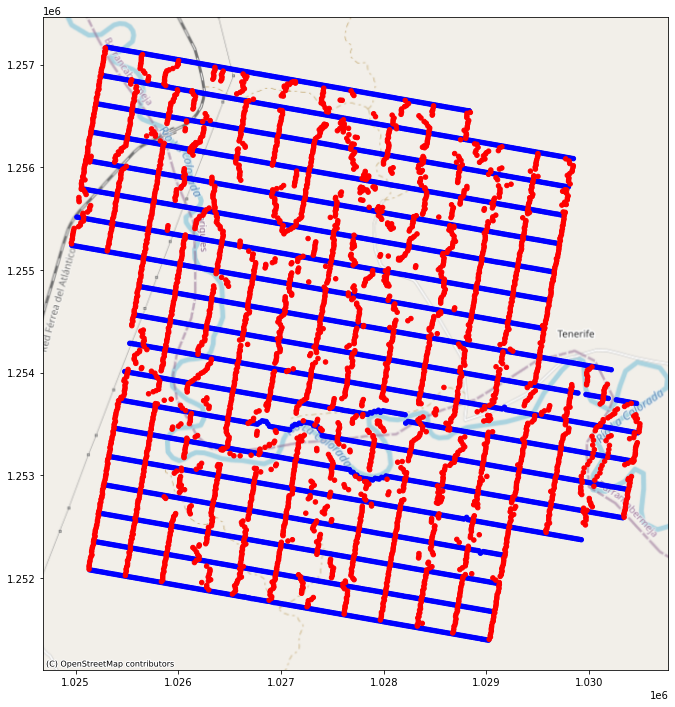

In [10]:
import contextily as cx
ax = survey.plot(figsize=(12,12), column='TYPE', cmap="bwr", markersize=20)
cx.add_basemap(ax, crs=survey.crs, source=cx.providers.OpenStreetMap.Mapnik)

### 1.2. Calcular parámetros de la geometría

In [11]:
NS = source_survey.shape[0]
NR = receiver_survey.shape[0]
print('Number of Sources =', NS)
print('Number of Receivers = ', NR)

Number of Sources = 3395
Number of Receivers =  4332


In [12]:
#Calculate number of receiver lines and number of receivers on each line
def calculate_rec_params(receiver_survey):
    temprec = np.asarray(receiver_survey.RECEIVERSE)
    rec_lines, rec_per_line = np.unique(temprec, return_counts=True)
    NRL = rec_lines.size # Number of receiver lines    
    return rec_lines, rec_per_line, NRL

rec_lines, rec_per_line, NRL = calculate_rec_params(receiver_survey)
print('Receiver lines: ', rec_lines)
print('Receivers on each line: ', rec_per_line) #number of receivers per line
print('Number of receiver lines: ', NRL)

Receiver lines:  ['R3000' 'R3014' 'R3028' 'R3042' 'R3056' 'R3070' 'R3084' 'R3098' 'R3112'
 'R3126' 'R3140' 'R3154' 'R3168' 'R3182' 'R3196' 'R3210' 'R3224' 'R3238'
 'R3252']
Receivers on each line:  [198 198 198 198 234 252 252 252 252 243 234 235 234 234 234 234 234 234
 182]
Number of receiver lines:  19


Info organizada de la geometría (Receptoras)

In [13]:
Rec_info = pd.DataFrame(rec_lines, columns =['RECEIVERSE'])
Rec_info['type'] = 'receiver'
Rec_info['amount'] = rec_per_line
Rec_info.head()

,RECEIVERSE,type,amount
0,R3000,receiver,198
1,R3014,receiver,198
2,R3028,receiver,198
3,R3042,receiver,198
4,R3056,receiver,234


In [14]:
#Calculate number of source lines and number of sources on each line
def calculate_sou_params(source_survey):
    tempsrc = np.asarray(source_survey.SHOTSEQ)
    src_lines, src_per_line = np.unique(tempsrc, return_counts=True)
    NSL = src_lines.size # Number of source lines
    return src_lines, src_per_line, NSL

src_lines, src_per_line, NSL = calculate_sou_params(source_survey)

print('Source lines: ', src_lines)
print('Sources on each line: ', src_per_line)#number of sources per line
print('Number of source lines: ', NSL)

#Otras formas de calcular el numero de fuentes en cada linea
#shot_count = source_survey.groupby('SHOTSEQ')['UNKNOWN'].count()
#shot_count = source_survey['SHOTSEQ'].value_counts()
#print(shot_count)


Source lines:  ['S1000' 'S1001' 'S1002' 'S1003' 'S1004' 'S1005' 'S1006' 'S1014' 'S1015'
 'S1016' 'S1017' 'S1018' 'S1019' 'S1020' 'S1021' 'S1023' 'S1027' 'S1029'
 'S1030' 'S1031' 'S1032' 'S1034' 'S1036' 'S1037' 'S1038' 'S1040' 'S1041'
 'S1042' 'S1043' 'S1044' 'S1045' 'S1046' 'S1047' 'S1048' 'S1049' 'S1050'
 'S1051' 'S1052' 'S1053' 'S1054' 'S1055' 'S1056' 'S1058' 'S1059' 'S1061'
 'S1062' 'S1063' 'S1064' 'S1065' 'S1066' 'S1067' 'S1068' 'S1069' 'S1070'
 'S1071' 'S1072' 'S1073' 'S1074' 'S1075' 'S1076' 'S1077' 'S1078' 'S1079'
 'S1080' 'S1081' 'S1084' 'S1085' 'S1086' 'S1087' 'S1088' 'S1089' 'S1090'
 'S1091' 'S1092' 'S1093' 'S1094' 'S1095' 'S1096' 'S1097' 'S1098' 'S1099'
 'S1100' 'S1101' 'S1102' 'S1103' 'S1104' 'S1105' 'S1106' 'S1107' 'S1108'
 'S1109' 'S1110' 'S1111' 'S1112' 'S1113' 'S1114' 'S1115' 'S1117' 'S1118'
 'S1119' 'S1120' 'S1121' 'S1122' 'S1123' 'S1124' 'S1125' 'S1126' 'S1127'
 'S1128' 'S1129' 'S1130' 'S1131' 'S1132' 'S1133' 'S1134' 'S1135' 'S1136'
 'S1137' 'S1138' 'S1139' 'S1140' 'S1

In [15]:
Sou_info = pd.DataFrame(src_lines, columns =['SHOTSEQ'])
Sou_info['type'] = 'source'
Sou_info['amount'] = src_per_line
Sou_info.head(20)

,SHOTSEQ,type,amount
0,S1000,source,82
1,S1001,source,2
2,S1002,source,6
3,S1003,source,5
4,S1004,source,3
5,S1005,source,1
6,S1006,source,3
7,S1014,source,4
8,S1015,source,5
9,S1016,source,2


#### Calcular distancia entre fuentes para cada línea 

In [19]:
def calculate_srcdist(temps,coord):
    temps = temps.sort_values(by=[coord])    #Ordenar los puntos de una línea de norte a sur
    temps['idx'] = range(temps.shape[0])       #Asignar indice segun el orden de los puntos en la línea 
    temps = temps[['SHOTSEQ','geometry','idx']]  #Extraer solo la geometria y el indice de cada registro
    copy1_temps = temps['geometry'][:-1] #From first to penultimate
    copy2_temps = temps['geometry'][1:] #From second to last
    temps['distances'] = copy2_temps.distance(copy1_temps, align=False)  #Calcular distancia de un shot con el anterior
    temps.iloc[0,3] = 0    #Fijar la distancia del primer shot en cada línea en cero (porque calculo la distancia de un shot con el anterior)
    return temps
    

sourcedist_df = pd.DataFrame(columns = ['SHOTSEQ', 'geometry', 'idx', 'distances']) #Crear dataframe global vacío

for line in src_lines:
    temp_df = source_survey[source_survey['SHOTSEQ']==line]
    temp_df = calculate_srcdist(temp_df,'NORTE')
    sourcedist_df = sourcedist_df.append(temp_df)    #Agregar los registros de la línea de shot analizada al dataframe global
    

In [20]:
sourcedist_df.head()

,SHOTSEQ,geometry,idx,distances
2215,S1000,POINT (1024962.000 1255255.100),0,0.000000
2242,S1000,POINT (1024959.700 1255265.600),1,10.748953
2265,S1000,POINT (1024966.800 1255293.300),2,28.595454
2275,S1000,POINT (1024969.900 1255307.300),3,14.339107
2287,S1000,POINT (1024971.600 1255332.200),4,24.957965


#### Calcular distancia promedio entre fuentes de cada línea

Observación: Estos promedios tienen outliers debido a las fuentes ubicadas en off-set que generan líneas de disparos intermedias, con un número muy reducido de fuentes (hasta una sola fuente). Por eso en el paso anterior se descartaron las líneas con una cantidad reducida de fuentes.

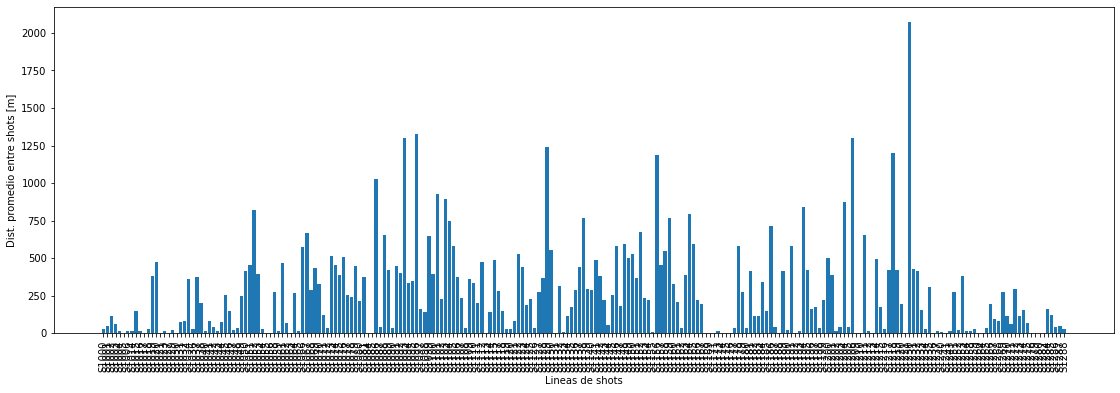

In [22]:
avg_shot_dist = sourcedist_df.groupby('SHOTSEQ')['distances'].mean()

plt.figure(figsize=(19, 6))
#plt.bar(src_lines,avg_shot_dist) #Antes de seleccionar subconjunto de líneas
plt.bar(src_lines,avg_shot_dist)
plt.xticks(rotation='vertical')
plt.xlabel('Lineas de shots')
plt.ylabel('Dist. promedio entre shots [m]')
plt.show()

#avg_shot_dist.head(18)

In [23]:
#Distancia promedio entre fuentes para todas las líneas
print('Dist. promedio entre shots/linea = ',avg_shot_dist.mean())
print('Std. dev dist. entre shots/linea = ',avg_shot_dist.std())
#Numero de total de shots
print('Numero total de shots = ',sourcedist_df.shape[0])


Dist. promedio entre shots/linea =  264.21496005175885
Std. dev dist. entre shots/linea =  305.0172098033692
Numero total de shots =  3395


#### Calcular distancia entre receptores para cada línea

In [24]:
def calculate_recdist(temps,coord):
    temps = temps.sort_values(by=[coord])    #Ordenar los puntos de una línea de norte a sur
    temps['idx'] = range(temps.shape[0])       #Asignar indice segun el orden de los puntos en la línea 
    temps = temps[['RECEIVERSE','geometry','idx']]  #Extraer solo la geometria y el indice de cada registro
    copy1_temps = temps['geometry'][:-1] #From first to penultimate
    copy2_temps = temps['geometry'][1:] #From second to last
    temps['distances'] = copy2_temps.distance(copy1_temps, align=False)  #Calcular distancia de un shot con el anterior
    temps.iloc[0,3] = 0    #Fijar la distancia del primer shot en cada línea en cero
    return temps

receivdist_df = pd.DataFrame(columns = ['RECEIVERSE', 'geometry', 'idx', 'distances']) #Crear dataframe global vacío

for line in rec_lines:
    temp_df = receiver_survey[receiver_survey['RECEIVERSE']==line]
    temp_df = calculate_recdist(temp_df,'ESTE')        
    receivdist_df = receivdist_df.append(temp_df)    #Agregar los registros de la línea de receptores analizada al dataframe global
    

In [25]:
receivdist_df.head()

,RECEIVERSE,geometry,idx,distances
0,R3000,POINT (1025139.000 1252080.900),0,0.000000
1,R3000,POINT (1025158.300 1252077.600),1,19.580092
2,R3000,POINT (1025178.600 1252074.000),2,20.616741
3,R3000,POINT (1025198.000 1252070.600),3,19.695685
4,R3000,POINT (1025217.600 1252067.300),4,19.875865


#### Calcular distancias promedio para cada línea de receptoras
Observación: La distancia promedio en cada línea no se ve afectada debido a que no hay casos de receptoras ubicadas en offset.

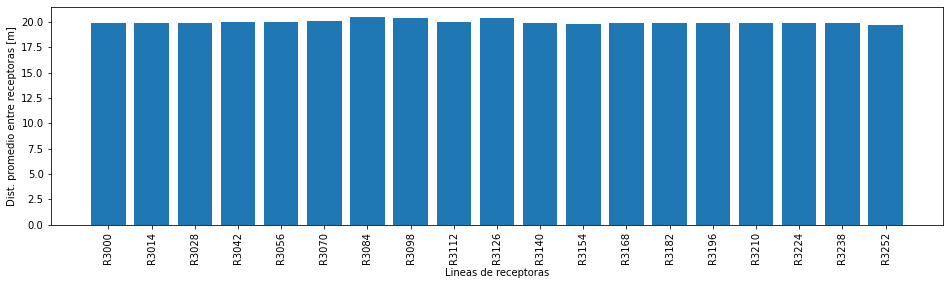

In [26]:
avg_receiv_dist = receivdist_df.groupby('RECEIVERSE')['distances'].mean()

plt.figure(figsize=(16, 4))
plt.bar(rec_lines,avg_receiv_dist)
plt.xticks(rotation='vertical')
plt.xlabel('Lineas de receptoras')
plt.ylabel('Dist. promedio entre receptoras [m]')
#plt.grid(axis = 'y')
plt.show()

#avg_receiv_dist.head(18)

#### Calcular distancia entre líneas de shots

In [27]:
temp_este = source_survey.groupby(['SHOTSEQ'])['ESTE'].mean().reset_index()

temp_este.head()

,SHOTSEQ,ESTE
0,S1000,1.025146e+06
1,S1001,1.025084e+06
2,S1002,1.025117e+06
3,S1003,1.025070e+06
4,S1004,1.025079e+06


In [29]:
copy1_temp_este = temp_este['ESTE'][:-1] #From first to penultimate
copy2_temp_este = temp_este['ESTE'][1:] #From second to last
aaaaaa = copy2_temp_este.distance(copy1_temp_este, align=False)  #Calcular distancia de un shot con el anterior
#aaaaaa=aaaaaa[1:]
print(aaaaaa)
#for line in temp_este['SHOTSEQ']:
#    temp_ddf = source_survey[source_survey['SHOTSEQ']==line]
#    temp_ddf = calculate_srcdist(temp_ddf,'ESTE')
#    sourcelinedist_df = sourcelinedist_df.append(temp_ddf)    #Agregar los registros de la línea de shot analizada al dataframe global


AttributeError: 'Series' object has no attribute 'distance'

In [27]:
print(temp_este['ESTE'].size)

237


In [110]:
copy1_temp_este = temp_este['ESTE'][:-1] #From first to penultimate
copy2_temp_este = temp_este['ESTE'][1:] #From second to last
temp_dist= copy2_temp_este.distance(copy1_temp_este, align=False)  #Calcular distancia de una linea con la anterior
print(temp_dist)

KeyError: 'ESTE'

### 2. Generar geometrías de sub-muestreo

#### 2.1. Truncar las líneas de fuentes que tengan menos de cierta cantidad de fuentes

In [50]:
src_lines, src_per_line, NSL = calculate_sou_params(source_survey)

def generate_sub_sourgeom(source_survey, src_per_line, tau):
    inds = np.where(src_per_line >tau) # 22 es el umbral para obtener 17 lineas fuentes como dice el reporte observador
    trunc_src_lines = src_lines[inds]
    sub_source_df = source_survey.loc[source_survey['SHOTSEQ'].isin(trunc_src_lines)]
    #sourcedist_df = sourcedist_df.loc[sourcedist_df['SHOTSEQ'].isin(trunc_src_lines)]
    return sub_source_df, trunc_src_lines

tau = 10
source_trunc, trunc_src_lines = generate_sub_sourgeom(source_survey, src_per_line, tau)
source_trunc.head()


,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO,ESTE,NORTE,ELEVACION,TYPE,geometry
0,S1054,300010.0,13.0,21,55,1025485.1,1252025.5,80.3333160428,source,POINT (1025485.100 1252025.500)
1,S1095,300010.0,13.0,31,56,1026296.5,1251886.5,105.9333161554,source,POINT (1026296.500 1251886.500)
2,S1216,3000100.0,8.5,9,57,1028671.4,1251467.3,82.5333162006,source,POINT (1028671.400 1251467.300)
3,S1198,3000100.0,7.5,6,58,1028326.9,1251533.7,82.6333162053,source,POINT (1028326.900 1251533.700)
4,S1162,3000100.0,8.5,14,59,1027614.4,1251650.9,81.8333162219,source,POINT (1027614.400 1251650.900)


In [51]:
#Calcular distancia entre shots de la misma linea de la geometria sub-muestreada
def calculate_srcdist(temps,coord):
    temps = temps.sort_values(by=[coord])    #Ordenar los puntos de una línea de norte a sur
    temps['idx'] = range(temps.shape[0])       #Asignar indice segun el orden de los puntos en la línea 
    temps = temps[['SHOTSEQ','geometry','idx']]  #Extraer solo la geometria y el indice de cada registro
    copy1_temps = temps['geometry'][:-1] #From first to penultimate
    copy2_temps = temps['geometry'][1:] #From second to last
    temps['distances'] = copy2_temps.distance(copy1_temps, align=False)  #Calcular distancia de un shot con el anterior
    temps.iloc[0,3] = 0    #Fijar la distancia del primer shot en cada línea en cero (porque calculo la distancia de un shot con el anterior)
    return temps
    

sub_sourcedist_df = pd.DataFrame(columns = ['SHOTSEQ', 'geometry', 'idx', 'distances']) #Crear dataframe global vacío

for line in trunc_src_lines:
    temp_df = source_trunc[source_trunc['SHOTSEQ']==line]
    temp_df = calculate_srcdist(temp_df,'NORTE')
    sub_sourcedist_df = sub_sourcedist_df.append(temp_df)    #Agregar los registros de la línea de shot analizada al dataframe global
    

#### 2.2. Calcular todos los parámetros de fuentes de la geometria submuestreada

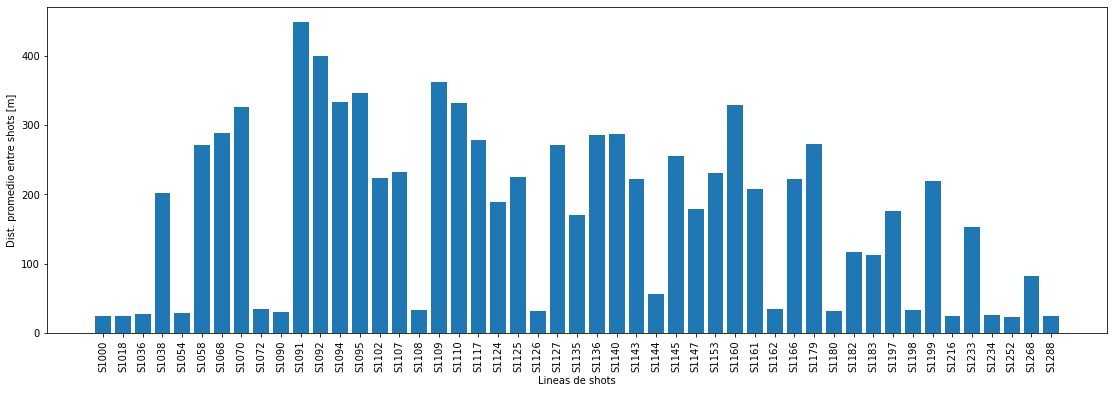

Dist. promedio entre shots/linea =  178.3004159082483
Std. dev dist. entre shots/linea =  123.8670695545404
Numero total de shots =  2617


In [52]:
def calculate_geometry_params(gdf):
    #Calcular distancia promedio de shots por linea y graficar
    avg_shot_dist = gdf.groupby('SHOTSEQ')['distances'].mean()
    %matplotlib inline 
    plt.figure(figsize=(19, 6))
    plt.bar(trunc_src_lines,avg_shot_dist)
    plt.xticks(rotation='vertical')
    plt.xlabel('Lineas de shots')
    plt.ylabel('Dist. promedio entre shots [m]')
    plt.show()
    
    return(avg_shot_dist, gdf, trunc_src_lines)
    
(avg_shots,trunc_gdf, trunc_src_lines) = calculate_geometry_params(sub_sourcedist_df)
    
#Imprimir resultados
print('Dist. promedio entre shots/linea = ',avg_shots.mean()) #Distancia promedio entre fuentes para todas las líneas
print('Std. dev dist. entre shots/linea = ',avg_shots.std()) #Desviacion estandar distancia 
print('Numero total de shots = ',trunc_gdf.shape[0])  #Numero de total de shots

    


    

#### 2.3. Graficar geometría sub-muestreada

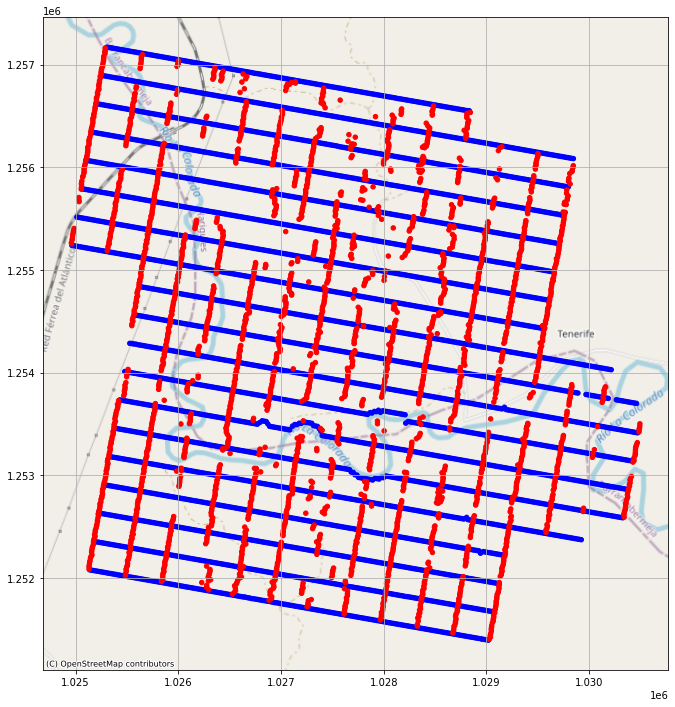

In [53]:
source_trunc = source_survey.loc[source_survey['SHOTSEQ'].isin(trunc_src_lines)] 
survey = receiver_survey.append(source_trunc)
ax = survey.plot(figsize=(12,12), column='TYPE', cmap="bwr", markersize=20)
cx.add_basemap(ax, crs=survey.crs, source=cx.providers.OpenStreetMap.Mapnik)
plt.grid()
plt.show()

#### 2.4. Guardar geometría sub-muestreada como archivo shape

In [54]:
filepath = '../data_geometry/Subsampled_Geometries/Tenerife_GeometriaSub_tau='+str(tau)+'.shp'
survey.to_file(filepath)  

### 3. Calcular Fold 

#### 3.1. Cargar y preparar los datos para calcular el mapa de fold

In [4]:
#Cargar archivo de geometría (si no se ha cargado antes)
#tau = 22
#filename = '../data_geometry/Subsampled_Geometries/Tenerife_GeometriaSub_tau='+str(tau)+'.shp'
filename = '../data_geometry/Subsampled_Geometries/Tenerife_GeometriaSub_Gap=78.shp'
survey = gpd.GeoDataFrame.from_file(filename)

In [5]:
#Make a Station ID column, so we can recognize the stations again.
sid = np.arange(len(survey))
survey['SID'] = sid

In [6]:
s2 = survey.rotate(10, origin=survey.unary_union.centroid)
s2

0       POINT (1025548.040 1251698.482)
1       POINT (1025567.620 1251698.583)
2       POINT (1025588.237 1251698.563)
3       POINT (1025607.932 1251698.584)
4       POINT (1025627.808 1251698.737)
                     ...               
6931    POINT (1026672.778 1256722.720)
6932    POINT (1028397.735 1256671.172)
6933    POINT (1027935.758 1256607.585)
6934    POINT (1026696.567 1256712.191)
6935    POINT (1028422.907 1256727.093)
Length: 6936, dtype: geometry

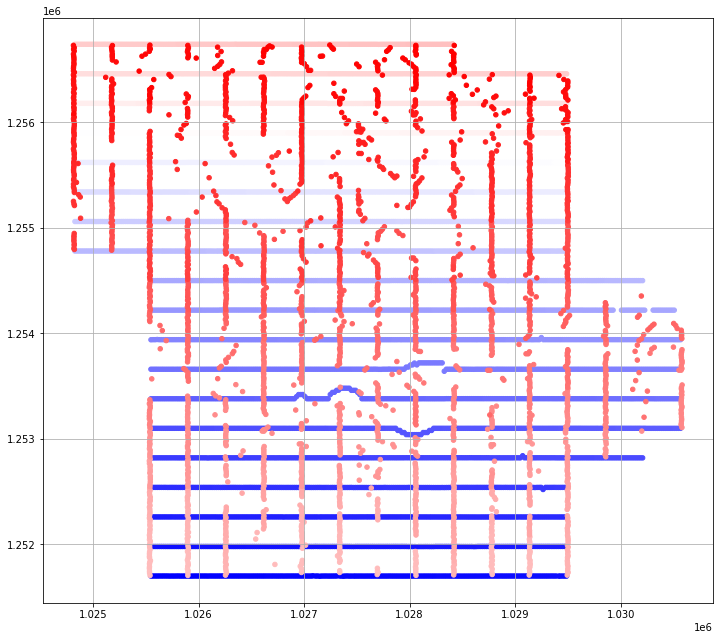

In [7]:
s2.plot(figsize=(12,12), cmap="bwr", markersize=20)
plt.grid()
plt.show()

#### 3.2. Calcular puntos medios en la geometría

In [8]:
NS = survey[survey['TYPE']=='source'].shape[0]
NR = survey[survey['TYPE']=='receiver'].shape[0]
print('Number of Sources =', NS)
print('Number of Receivers = ', NR)

Number of Sources = 2604
Number of Receivers =  4332


In [9]:
#Calculate midpoints
rcvrs = s2[0:NR-1]
srcs = s2[NR:]

midpoint_list = [LineString([r, s]).interpolate(0.5, normalized=True)
                 for r in rcvrs
                 for s in srcs]

In [10]:
# Make a list of all the offsets when we count the midpoints into the bins.
offsets = [r.distance(s)
           for r in rcvrs
           for s in srcs]

azimuths = [np.arctan((r.x - s.x)/(r.y - s.y))
            for r in rcvrs
            for s in srcs]

In [11]:
# Make a Geoseries of the midpoints, offsets and azimuths:
midpoints = gpd.GeoDataFrame({'geometry': midpoint_list,
                              'offset': offsets,
                              'azimuth': np.degrees(azimuths),
                              })

midpoints[:5]


,geometry,offset,azimuth
0,POINT (1025723.271 1251701.252),350.505877,89.094151
1,POINT (1027340.683 1251703.040),3585.297020,89.854307
2,POINT (1027165.285 1251705.825),3234.522260,89.739850
3,POINT (1026804.271 1251701.673),2512.469932,89.854476
4,POINT (1025543.913 1251701.156),9.835141,-57.060111


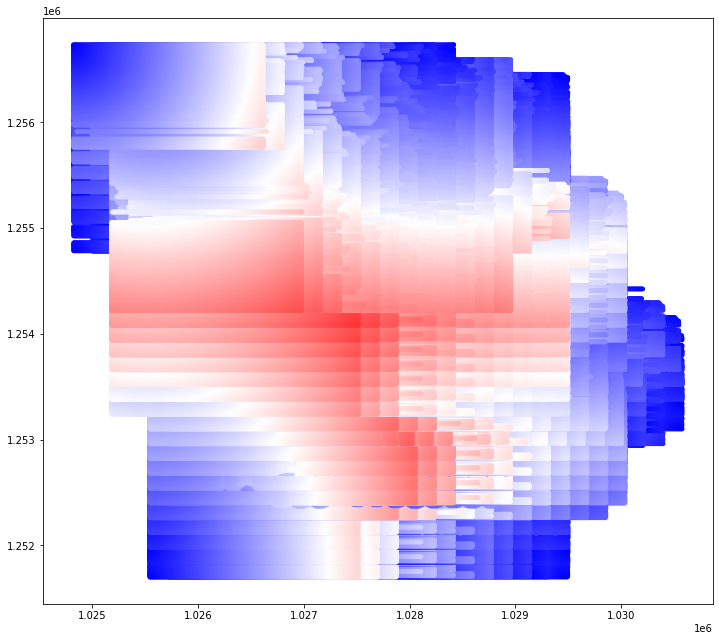

In [12]:
ax = midpoints.plot(figsize=(12,12),column='offset', cmap="bwr", markersize=15)

In [13]:
#Spider plot (Might not be needed, but just in case)
midpoints['offsetx'] = offsets * np.cos(azimuths)
midpoints['offsety'] = offsets * np.sin(azimuths)
midpoints[:5].offsetx  # Easy!

0     5.541285
1     9.116786
2    14.686223
3     6.381365
4     5.347945
Name: offsetx, dtype: float64

In [14]:
x = [m.geometry.x for i, m in midpoints.iterrows()]
y = [m.geometry.y for i, m in midpoints.iterrows()]

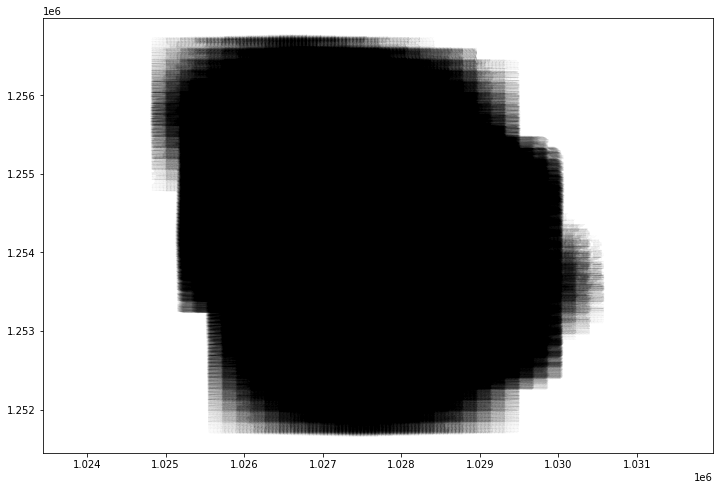

In [23]:
#%matplotlib qt
fig = plt.figure(figsize=(12,8))
plt.quiver(x, y, midpoints.offsetx, midpoints.offsety, units='xy', width=0.5, scale=1/0.025, pivot='mid', headlength=0)
plt.axis('equal')
plt.show()

#### 3.3. Crear los bins a partir de la geometría ideal

In [15]:
#BINS - Created as new geometry from the ideal geometry (pre-plot)
# Parameters from report
si = 20            # Source point interval (m)
ri = 20            # Receiver point interval (m)
extent_c = s2.total_bounds 
extent = [extent_c[2]-extent_c[0], extent_c[3]-extent_c[1]]
#Extract coordinates of the bottom-left point
xmi = extent_c[0] #Easting of bottom-left corner of grid (m)
ymi = extent_c[1] #Northing of bottom-left corner (m)
rperline = int(extent[0]/ri) + 2
sperline = int(extent[1]/si) + 2

In [16]:
extent

[5769.373822248774, 5042.510292393621]

In [17]:
# Load preplot geometry
pre_r_survey = gpd.GeoDataFrame.from_file('../data_geometry/receiver_PREPLOT_shapefile/receiver_PREPLOT_shapefile.shp')
pre_s_survey = gpd.GeoDataFrame.from_file('../data_geometry/source_PREPLOT_shapefile/source_PREPLOT_shapefile.shp')
pre_r_survey['TYPE']='receiver'
pre_s_survey['TYPE']='source'

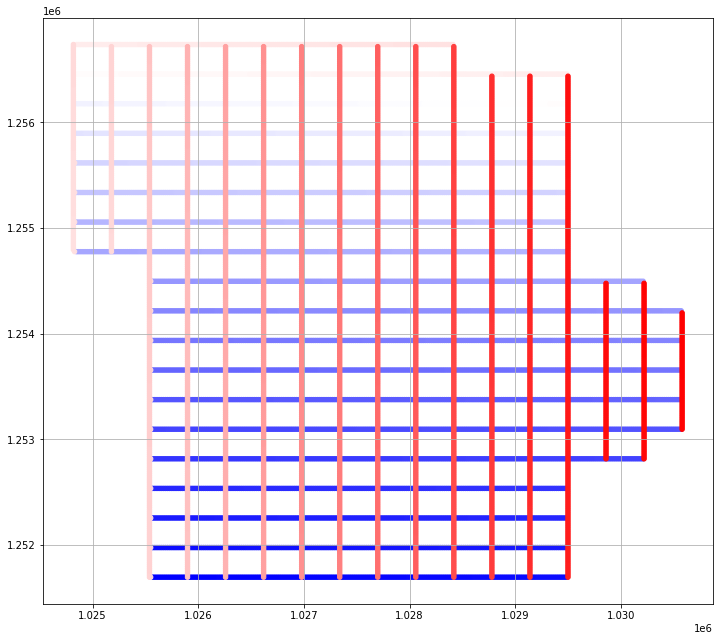

In [18]:
pre_survey = pre_r_survey.append(pre_s_survey)
#pre_survey.plot(figsize=(12,12), column='TYPE', cmap="bwr", markersize=20)
#plt.grid()
#plt.show()
pre_survey_rot = pre_survey.rotate(10, origin=pre_survey.unary_union.centroid)
pre_survey_rot.plot(figsize=(12,12), cmap="bwr", markersize=20)
plt.grid()
plt.show()


In [19]:
#Create the bin centres
# Factor to shift the bins relative to source and receiver points
jig = si / 2.
bin_centres = gpd.GeoSeries([Point(xmi + 0.5*r*ri + jig, ymi + 0.5*s*si + jig)
                             for r in range(2*rperline - 3)
                             for s in range(2*sperline - 2)
                            ])

# Buffers are diamond shaped so we have to scale and rotate them.
scale_factor = np.sin(np.pi/4.)/2.
bin_polys = bin_centres.buffer(scale_factor*ri, 1).rotate(-45)
bins = gpd.GeoDataFrame(geometry=bin_polys)

bins[:3]

,geometry
0,"POLYGON ((1024828.318 1251701.898, 1024818.318..."
1,"POLYGON ((1024828.318 1251711.898, 1024818.318..."
2,"POLYGON ((1024828.318 1251721.898, 1024818.318..."


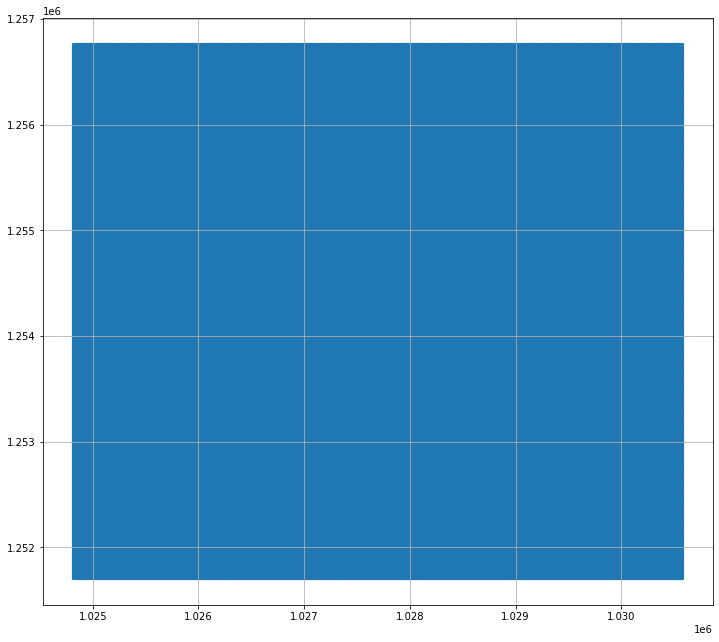

In [29]:
bin_centres.plot(figsize=(12,12), markersize=5)
plt.grid()
plt.show()

In [30]:
%matplotlib qt
#%matplotlib inline #To display image within the cell
bins.plot(figsize=(12,12), edgecolor="black") #Paul grafica la geometría encima, y los centros de los bins

<AxesSubplot:>

In [20]:
bins['seqbin']=range(291962) #Number of bins obtained from bin_centres.shape
bins

,geometry,seqbin
0,"POLYGON ((1024828.318 1251701.898, 1024818.318...",0
1,"POLYGON ((1024828.318 1251711.898, 1024818.318...",1
2,"POLYGON ((1024828.318 1251721.898, 1024818.318...",2
3,"POLYGON ((1024828.318 1251731.898, 1024818.318...",3
4,"POLYGON ((1024828.318 1251741.898, 1024818.318...",4
...,...,...
291957,"POLYGON ((1030588.318 1256711.898, 1030578.318...",291957
291958,"POLYGON ((1030588.318 1256721.898, 1030578.318...",291958
291959,"POLYGON ((1030588.318 1256731.898, 1030578.318...",291959
291960,"POLYGON ((1030588.318 1256741.898, 1030578.318...",291960


#### 3.4. Calcular el mapa de fold para la geometría

In [21]:
def bin_the_midpoints(midpoints,bins):
    pointsInPolygon = gpd.sjoin(midpoints,bins, how="inner", op='intersects')
    pointsInPolygon['fold']=1
    pointsInPolygon.groupby('seqbin').sum()
    return gpd.GeoDataFrame(bins.join(pointsInPolygon.groupby('seqbin').sum()['fold']))

In [22]:
fold = bin_the_midpoints(midpoints,bins)#.fillna(-1) #Paul quita fillna(-1)
fold['fold']=np.ceil(fold['fold'].values/2)
%matplotlib qt
fold.plot(column='fold',cmap='jet',edgecolor="None",legend=True, figsize=(10,12))
plt.show()

/Users/correa/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
print(tau)

18


### 4. Geometría sub-muestreada por distancia máxima de 'gap'

#### 4.1 Cargar los archivos de la geometría total

In [4]:
##Cargar archivo de geometría sub-muestreada (generada anteriormente)
#tau = 10
#survey = gpd.GeoDataFrame.from_file('../data_geometry/Subsampled_Geometries/Tenerife_GeometriaSub_tau='+str(tau)+'.shp')
#survey.head()

#Cargar geometria original (sin sub-muestrear)
receiver_survey = gpd.GeoDataFrame.from_file('../data_geometry/receiver_POSTPLOT_shapefile/receiver_shapes_tenerife.shp')
source_survey = gpd.GeoDataFrame.from_file('../data_geometry/source_POSTPLOT_shapefile/source_shapes_tenerife.shp')
#survey = receiver_survey.append(source_survey)
#survey
source_survey

,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO,ESTE,NORTE,ELEVACION,TYPE,geometry
0,S1054,300010.0,13.0,21,55,1025485.1,1252025.5,80.3333160428,source,POINT (1025485.100 1252025.500)
1,S1095,300010.0,13.0,31,56,1026296.5,1251886.5,105.9333161554,source,POINT (1026296.500 1251886.500)
2,S1216,3000100.0,8.5,9,57,1028671.4,1251467.3,82.5333162006,source,POINT (1028671.400 1251467.300)
3,S1198,3000100.0,7.5,6,58,1028326.9,1251533.7,82.6333162053,source,POINT (1028326.900 1251533.700)
4,S1162,3000100.0,8.5,14,59,1027614.4,1251650.9,81.8333162219,source,POINT (1027614.400 1251650.900)
...,...,...,...,...,...,...,...,...,...,...
3390,S1156,324510.0,13.0,83,600,1028342.9,1256500.8,96.6348114928,source,POINT (1028342.900 1256500.800)
3391,S1094,325110.0,13.0,223,601,1027140.7,1256832.3,127.2348115211,source,POINT (1027140.700 1256832.300)
3392,S1179,325010.0,13.0,133,602,1028810.2,1256524.9,136.7348115257,source,POINT (1028810.200 1256524.900)
3393,S1094,325010.0,13.0,213,603,1027140.7,1256819.0,127.5348115334,source,POINT (1027140.700 1256819.000)


In [5]:
#Solo ejecutar cuando se carga una geometria sub-muestreada (No recomendado)
#source_survey = survey[survey['TYPE']=='source']
#source_survey.head()

,RECEIVERSE,UNKNOWN2,ESTE,NORTE,ELEVACION,UNKNOWN2_1,TYPE,geometry,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO
0,NaN,NaN,1025485.1,1252025.5,80.3333160428,NaN,source,POINT (1025485.100 1252025.500),S1054,300010.0,13.0,21.0,55.0
1,NaN,NaN,1026296.5,1251886.5,105.9333161554,NaN,source,POINT (1026296.500 1251886.500),S1095,300010.0,13.0,31.0,56.0
2,NaN,NaN,1028671.4,1251467.3,82.5333162006,NaN,source,POINT (1028671.400 1251467.300),S1216,3000100.0,8.5,9.0,57.0
3,NaN,NaN,1028326.9,1251533.7,82.6333162053,NaN,source,POINT (1028326.900 1251533.700),S1198,3000100.0,7.5,6.0,58.0
4,NaN,NaN,1027614.4,1251650.9,81.8333162219,NaN,source,POINT (1027614.400 1251650.900),S1162,3000100.0,8.5,14.0,59.0


#### 4.2 Calcular líneas de fuentes y número de fuentes

In [5]:
#Definir la funcion de calculo de lineas fuente y fuentes por linea para no tener que ejecutar celdas de 
# secciones anteriores

def calculate_sou_params(source_survey):
    tempsrc = np.asarray(source_survey.SHOTSEQ)
    src_lines, src_per_line = np.unique(tempsrc, return_counts=True)
    NSL = src_lines.size # Number of source lines
    return src_lines, src_per_line, NSL



In [6]:
src_lines, src_per_line, NSL = calculate_sou_params(source_survey)
print('Lineas fuente:'+str(src_lines))
print('Fuentes por linea:'+str(src_per_line))

Lineas fuente:['S1000' 'S1001' 'S1002' 'S1003' 'S1004' 'S1005' 'S1006' 'S1014' 'S1015'
 'S1016' 'S1017' 'S1018' 'S1019' 'S1020' 'S1021' 'S1023' 'S1027' 'S1029'
 'S1030' 'S1031' 'S1032' 'S1034' 'S1036' 'S1037' 'S1038' 'S1040' 'S1041'
 'S1042' 'S1043' 'S1044' 'S1045' 'S1046' 'S1047' 'S1048' 'S1049' 'S1050'
 'S1051' 'S1052' 'S1053' 'S1054' 'S1055' 'S1056' 'S1058' 'S1059' 'S1061'
 'S1062' 'S1063' 'S1064' 'S1065' 'S1066' 'S1067' 'S1068' 'S1069' 'S1070'
 'S1071' 'S1072' 'S1073' 'S1074' 'S1075' 'S1076' 'S1077' 'S1078' 'S1079'
 'S1080' 'S1081' 'S1084' 'S1085' 'S1086' 'S1087' 'S1088' 'S1089' 'S1090'
 'S1091' 'S1092' 'S1093' 'S1094' 'S1095' 'S1096' 'S1097' 'S1098' 'S1099'
 'S1100' 'S1101' 'S1102' 'S1103' 'S1104' 'S1105' 'S1106' 'S1107' 'S1108'
 'S1109' 'S1110' 'S1111' 'S1112' 'S1113' 'S1114' 'S1115' 'S1117' 'S1118'
 'S1119' 'S1120' 'S1121' 'S1122' 'S1123' 'S1124' 'S1125' 'S1126' 'S1127'
 'S1128' 'S1129' 'S1130' 'S1131' 'S1132' 'S1133' 'S1134' 'S1135' 'S1136'
 'S1137' 'S1138' 'S1139' 'S1140' 'S11

#### 4.3 Identificar fuentes en offset usando umbral de número de fuentes por línea

In [7]:
#Definir funcion de identificacion de fuentes offset y agregar columna indicador

def id_offsources(source_survey, src_per_line, tau):
    inds = np.where(src_per_line <tau) # 22 es el umbral para obtener 17 lineas fuentes como dice el reporte observador
    trunc_src_lines = src_lines[inds]
    #sub_source_df = source_survey.loc[source_survey['SHOTSEQ'].isin(trunc_src_lines)]
    source_survey2 = source_survey
    #aaa = source_survey2['SHOTSEQ'].isin(trunc_src_lines)
    source_survey2.loc[source_survey2['SHOTSEQ'].isin(trunc_src_lines),'offset'] = 1 #Asignar 1 si el disparo esta en offset 
    return source_survey2, trunc_src_lines

In [8]:
tau2=22
source_trunc, trunc_src_lines = id_offsources(source_survey, src_per_line, tau2)
source_trunc['offset'] = source_trunc['offset'].fillna(0)
#print(np.count_nonzero(aaa))
#print(trunc_src_lines)

In [9]:
source_trunc

,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO,ESTE,NORTE,ELEVACION,TYPE,geometry,offset
0,S1054,300010.0,13.0,21,55,1025485.1,1252025.5,80.3333160428,source,POINT (1025485.100 1252025.500),0.0
1,S1095,300010.0,13.0,31,56,1026296.5,1251886.5,105.9333161554,source,POINT (1026296.500 1251886.500),1.0
2,S1216,3000100.0,8.5,9,57,1028671.4,1251467.3,82.5333162006,source,POINT (1028671.400 1251467.300),0.0
3,S1198,3000100.0,7.5,6,58,1028326.9,1251533.7,82.6333162053,source,POINT (1028326.900 1251533.700),0.0
4,S1162,3000100.0,8.5,14,59,1027614.4,1251650.9,81.8333162219,source,POINT (1027614.400 1251650.900),0.0
...,...,...,...,...,...,...,...,...,...,...,...
3390,S1156,324510.0,13.0,83,600,1028342.9,1256500.8,96.6348114928,source,POINT (1028342.900 1256500.800),1.0
3391,S1094,325110.0,13.0,223,601,1027140.7,1256832.3,127.2348115211,source,POINT (1027140.700 1256832.300),1.0
3392,S1179,325010.0,13.0,133,602,1028810.2,1256524.9,136.7348115257,source,POINT (1028810.200 1256524.900),1.0
3393,S1094,325010.0,13.0,213,603,1027140.7,1256819.0,127.5348115334,source,POINT (1027140.700 1256819.000),1.0


#### 4.4 Calcular distancia entre fuentes de la misma línea

In [10]:
def calculate_srcdist(temps,coord):
    temps = temps.sort_values(by=[coord])    #Ordenar los puntos de una línea de norte a sur
    temps['idx'] = range(temps.shape[0])       #Asignar indice segun el orden de los puntos en la línea 
    temps = temps[['SHOTSEQ','geometry','idx']]  #Extraer solo la geometria y el indice de cada registro
    copy1_temps = temps['geometry'][:-1] #From first to penultimate
    copy2_temps = temps['geometry'][1:] #From second to last
    temps['distances'] = copy2_temps.distance(copy1_temps, align=False)  #Calcular distancia de un shot con el anterior
    temps.iloc[0,3] = 0    #Fijar la distancia del primer shot en cada línea en cero (porque calculo la distancia de un shot con el anterior)
    return temps

sourcedist_df = pd.DataFrame(columns = ['SHOTSEQ', 'geometry', 'idx', 'distances']) #Crear dataframe global vacío

for line in src_lines:
    temp_df = source_survey[source_survey['SHOTSEQ']==line]
    temp_df = calculate_srcdist(temp_df,'NORTE')
    sourcedist_df = sourcedist_df.append(temp_df)    #Agregar los registros de la línea de shot analizada al dataframe global

    

In [11]:
sourcedist_df

,SHOTSEQ,geometry,idx,distances
2215,S1000,POINT (1024962.000 1255255.100),0,0.000000
2242,S1000,POINT (1024959.700 1255265.600),1,10.748953
2265,S1000,POINT (1024966.800 1255293.300),2,28.595454
2275,S1000,POINT (1024969.900 1255307.300),3,14.339107
2287,S1000,POINT (1024971.600 1255332.200),4,24.957965
...,...,...,...,...
1528,S1288,POINT (1030485.700 1253423.900),32,106.087228
1536,S1288,POINT (1030486.100 1253447.700),33,23.803361
1544,S1288,POINT (1030489.400 1253458.400),34,11.197321
1552,S1288,POINT (1030492.400 1253477.800),35,19.630588


In [19]:
source_survey2 = source_trunc.merge(sourcedist_df, on=['SHOTSEQ','geometry'], suffixes = ('','_y'))
#source_survey2.drop(source_survey2.filter(regex='_y$').columns, axis=1, inplace=True) #Remover columnas repetidas de geometria
source_survey2

,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO,ESTE,NORTE,ELEVACION,TYPE,geometry,offset,idx,distances
0,S1054,300010.0,13.0,21,55,1025485.1,1252025.5,80.3333160428,source,POINT (1025485.100 1252025.500),0.0,0,0.000000
1,S1095,300010.0,13.0,31,56,1026296.5,1251886.5,105.9333161554,source,POINT (1026296.500 1251886.500),1.0,0,0.000000
2,S1216,3000100.0,8.5,9,57,1028671.4,1251467.3,82.5333162006,source,POINT (1028671.400 1251467.300),0.0,0,0.000000
3,S1198,3000100.0,7.5,6,58,1028326.9,1251533.7,82.6333162053,source,POINT (1028326.900 1251533.700),0.0,0,0.000000
4,S1162,3000100.0,8.5,14,59,1027614.4,1251650.9,81.8333162219,source,POINT (1027614.400 1251650.900),0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,S1156,324510.0,13.0,83,600,1028342.9,1256500.8,96.6348114928,source,POINT (1028342.900 1256500.800),1.0,2,1681.888775
3391,S1094,325110.0,13.0,223,601,1027140.7,1256832.3,127.2348115211,source,POINT (1027140.700 1256832.300),1.0,14,13.300000
3392,S1179,325010.0,13.0,133,602,1028810.2,1256524.9,136.7348115257,source,POINT (1028810.200 1256524.900),1.0,12,22.614155
3393,S1094,325010.0,13.0,213,603,1027140.7,1256819.0,127.5348115334,source,POINT (1027140.700 1256819.000),1.0,13,1043.117836


#### 4.5 Identificar y "desactivar" fuentes con distancias menores al gap identificado

In [20]:
dmax = 78 # valor calculado reconstrucciones 77.721 
source_survey2['active'] = 1
source_survey2.loc[(source_survey2['offset']==1) & (source_survey2['distances']<dmax), 'active'] = 0
#source_survey2['active'] = source_survey2['active'].fillna(1)
source_survey2

,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO,ESTE,NORTE,ELEVACION,TYPE,geometry,offset,idx,distances,active
0,S1054,300010.0,13.0,21,55,1025485.1,1252025.5,80.3333160428,source,POINT (1025485.100 1252025.500),0.0,0,0.000000,1
1,S1095,300010.0,13.0,31,56,1026296.5,1251886.5,105.9333161554,source,POINT (1026296.500 1251886.500),1.0,0,0.000000,0
2,S1216,3000100.0,8.5,9,57,1028671.4,1251467.3,82.5333162006,source,POINT (1028671.400 1251467.300),0.0,0,0.000000,1
3,S1198,3000100.0,7.5,6,58,1028326.9,1251533.7,82.6333162053,source,POINT (1028326.900 1251533.700),0.0,0,0.000000,1
4,S1162,3000100.0,8.5,14,59,1027614.4,1251650.9,81.8333162219,source,POINT (1027614.400 1251650.900),0.0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,S1156,324510.0,13.0,83,600,1028342.9,1256500.8,96.6348114928,source,POINT (1028342.900 1256500.800),1.0,2,1681.888775,1
3391,S1094,325110.0,13.0,223,601,1027140.7,1256832.3,127.2348115211,source,POINT (1027140.700 1256832.300),1.0,14,13.300000,0
3392,S1179,325010.0,13.0,133,602,1028810.2,1256524.9,136.7348115257,source,POINT (1028810.200 1256524.900),1.0,12,22.614155,0
3393,S1094,325010.0,13.0,213,603,1027140.7,1256819.0,127.5348115334,source,POINT (1027140.700 1256819.000),1.0,13,1043.117836,1


In [21]:
source_trunc = source_survey2.loc[source_survey2['active']==1]
source_trunc

,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO,ESTE,NORTE,ELEVACION,TYPE,geometry,offset,idx,distances,active
0,S1054,300010.0,13.0,21,55,1025485.1,1252025.5,80.3333160428,source,POINT (1025485.100 1252025.500),0.0,0,0.000000,1
2,S1216,3000100.0,8.5,9,57,1028671.4,1251467.3,82.5333162006,source,POINT (1028671.400 1251467.300),0.0,0,0.000000,1
3,S1198,3000100.0,7.5,6,58,1028326.9,1251533.7,82.6333162053,source,POINT (1028326.900 1251533.700),0.0,0,0.000000,1
4,S1162,3000100.0,8.5,14,59,1027614.4,1251650.9,81.8333162219,source,POINT (1027614.400 1251650.900),0.0,0,0.000000,1
6,S1036,300010.0,13.0,36,61,1025131.8,1252087.6,98.3333162354,source,POINT (1025131.800 1252087.600),0.0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387,S1093,325110.0,13.0,233,597,1027119.1,1256833.5,126.1348114411,source,POINT (1027119.100 1256833.500),1.0,1,2595.917512,1
3388,S1179,324810.0,13.0,143,598,1028808.9,1256483.2,136.6348114438,source,POINT (1028808.900 1256483.200),1.0,10,126.325651,1
3390,S1156,324510.0,13.0,83,600,1028342.9,1256500.8,96.6348114928,source,POINT (1028342.900 1256500.800),1.0,2,1681.888775,1
3393,S1094,325010.0,13.0,213,603,1027140.7,1256819.0,127.5348115334,source,POINT (1027140.700 1256819.000),1.0,13,1043.117836,1


In [22]:
survey = receiver_survey.append(source_trunc)
survey

,RECEIVERSE,UNKNOWN2,ESTE,NORTE,ELEVACION,UNKNOWN2_1,TYPE,geometry,SHOTSEQ,UNKNOWN,DEPTHFT,UHT,ARCHIVO,offset,idx,distances,active
0,R3000,10371G1,1025139.0,1252080.9,92.0333,134217.0,receiver,POINT (1025139.000 1252080.900),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R3000,10381G1,1025158.3,1252077.6,91.5333,134217.0,receiver,POINT (1025158.300 1252077.600),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R3000,10391G1,1025178.6,1252074.0,94.7333,134217.0,receiver,POINT (1025178.600 1252074.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R3000,10401G1,1025198.0,1252070.6,97.1333,134217.0,receiver,POINT (1025198.000 1252070.600),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R3000,10411G1,1025217.6,1252067.3,100.0333,134217.0,receiver,POINT (1025217.600 1252067.300),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387,NaN,NaN,1027119.1,1256833.5,126.1348114411,NaN,source,POINT (1027119.100 1256833.500),S1093,325110.0,13.0,233.0,597.0,1.0,1,2595.917512,1.0
3388,NaN,NaN,1028808.9,1256483.2,136.6348114438,NaN,source,POINT (1028808.900 1256483.200),S1179,324810.0,13.0,143.0,598.0,1.0,10,126.325651,1.0
3390,NaN,NaN,1028342.9,1256500.8,96.6348114928,NaN,source,POINT (1028342.900 1256500.800),S1156,324510.0,13.0,83.0,600.0,1.0,2,1681.888775,1.0
3393,NaN,NaN,1027140.7,1256819.0,127.5348115334,NaN,source,POINT (1027140.700 1256819.000),S1094,325010.0,13.0,213.0,603.0,1.0,13,1043.117836,1.0


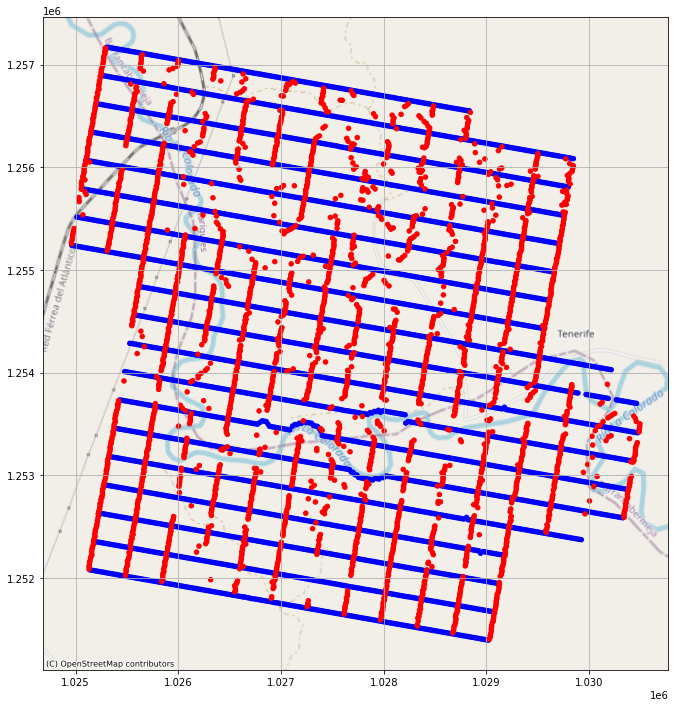

In [23]:
ax = survey.plot(figsize=(12,12), column='TYPE', cmap="bwr", markersize=20)
cx.add_basemap(ax, crs=survey.crs, source=cx.providers.OpenStreetMap.Mapnik)
plt.grid()
plt.show()

#### 4.6 Guardar geometría sub-muestreada como archivo shape

In [24]:
filepath = '../data_geometry/Subsampled_Geometries/Tenerife_GeometriaSub_Gap='+str(dmax)+'.shp'
survey.to_file(filepath)  

#### 4.7 Calcular todos los parámetros de fuentes de la geometria submuestreada

In [45]:
def calculate_geometry_params(gdf):
    #Calcular distancia promedio de shots por linea y graficar
    avg_shot_dist = gdf.groupby('SHOTSEQ')['distances'].mean()
    #%matplotlib inline 
    #plt.figure(figsize=(19, 6))
    #plt.bar(avg_shot_dist)
    #plt.xticks(rotation='vertical')
    #plt.xlabel('Lineas de shots')
    #plt.ylabel('Dist. promedio entre shots [m]')
    #plt.show()
    
    return(avg_shot_dist)
    
(avg_shots) = calculate_geometry_params(survey)
    
#Imprimir resultados
print('Dist. promedio entre shots/linea = ',avg_shots.mean()) #Distancia promedio entre fuentes para todas las líneas
print('Std. dev dist. entre shots/linea = ',avg_shots.std()) #Desviacion estandar distancia 
print('Numero total de shots = ',source_trunc.shape[0])  #Numero de total de shots
print('Numero total de lineas de shots = ', avg_shots.shape[0])    

Dist. promedio entre shots/linea =  857.1717566134237
Std. dev dist. entre shots/linea =  722.1762859682663
Numero total de shots =  2604
Numero total de lineas de shots =  176


In [38]:
###NO FUNCIONA LA GRAFIA - REVISAR COMO SE PUEDE ARREGLAR

#%matplotlib inline 
plt.figure(figsize=(19, 6))
plt.bar(,avg_shot_dist)
plt.xticks(rotation='vertical')
plt.xlabel('Lineas de shots')
plt.ylabel('Dist. promedio entre shots [m]')
plt.show()

TypeError: 'GeoDataFrame' object is not callable

<Figure size 1368x432 with 0 Axes>

In [27]:
## codigo de prueba de esta parte
avg_shot_dist = survey.groupby('SHOTSEQ')['distances'].mean()
print(avg_shot_dist)

SHOTSEQ
S1000     23.901488
S1001     96.734947
S1002    319.046962
S1003    132.137083
S1015    671.875852
            ...    
S1284    241.090032
S1285    443.795201
S1286    112.351279
S1287    165.336536
S1288     25.253685
Name: distances, Length: 176, dtype: float64


### Códigos de prueba: 
Crear columna idy con base en la coordenada ESTE y construir la matriz binaria de representación de la geometría, para calcular coherencia mutua

3286


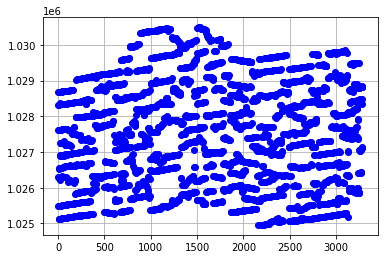

In [23]:
#Hacer matriz binaria de posiciones donde hay fuentes - no es posible usar la coordenada como indicador porque casi todos los shots tienen coordenada ESTE unica como se ve en la figura
print(source_survey.ESTE.unique().shape[0])
estes = source_survey.ESTE.unique()
plt.plot(estes, 'ob')
plt.grid()
plt.show()

Calculations required for the Fold:

In [90]:
#Save Fold as a shapefile
#fold.to_file('../data_geometry/Fold_Postplot/Fold_PostPlot_V1.shp')